In [1]:
import cobra
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

# Dynamic Flux Based Analaysis

In [2]:
%run Scaffold_Y_lipo.ipynb #Loading the model

In [3]:
medium = model.medium

medium['EX_so4_e'] = 1000
medium['EX_pi_e'] = 1000
medium['EX_o2_e'] = 1000
medium['EX_nh4_e'] = 1000
medium['EX_glc__D_e'] = 20
medium['EX_h2o_e'] = 1000

model.medium = medium
model.medium

glucose = model.reactions.EX_glc__D_e
biomass = model.reactions.BIOMASS_SC4_bal


Medium should be loaded directly from the optimized section

In [4]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_SC4_bal', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [5]:
ts = np.linspace(0, 15, 10)  # Desired integration resolution and interval
y0 = [0.1, 5]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 15.000: : 339it [15:02,  2.66s/it]


In [8]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.667e+00  3.333e+00  5.000e+00  6.667e+00
             8.333e+00  1.000e+01  1.167e+01  1.333e+01  1.500e+01]
        y: [[ 1.000e-01  2.148e-01 ...  5.866e-01  5.866e-01]
            [ 5.000e+00  3.820e+00 ...  3.981e-05  5.637e-06]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 333
     njev: 2
      nlu: 25

Text(0, 0.5, 'Glucose')

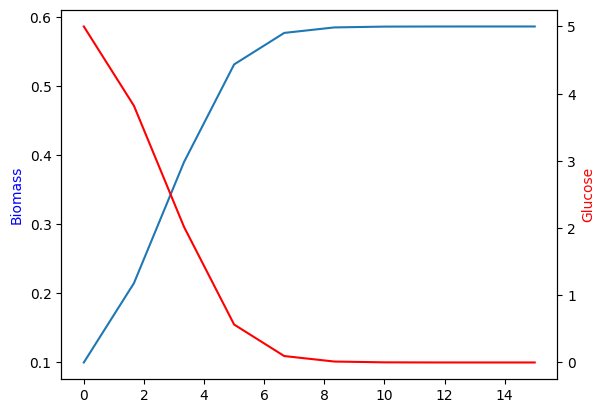

In [9]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')